In [88]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import warnings
warnings.filterwarnings('ignore')

from folium import plugins
import json
import requests
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

import seaborn as sns
import matplotlib.pyplot as plt

import dash
import dash_core_components as dcc
import dash_html_components as html

In [95]:
# load data
df=pd.read_excel('I:/Brandschadenstatistik_Recycling.xlsx')
df=df.drop(index=[0,1])
df=df.reset_index(drop=True)
df.head()

Nr. Tag      Datum   Uhrzeit                     Firma Land  \
0  138.0  SO 2019-06-16  22:00:00   Berliner Stadtreinigung   DE   
1  245.0  SA 2020-02-15  09:00:00           Alfred Hösli AG  CHE   
2   20.0  SA 2018-08-18       NaN             CRH Recycling   DE   
3  180.0  MI 2019-09-04       NaN               Mittelstädt   DE   
4  114.0  MO 2019-05-13  12:50:00  Heidemann Recycling GmbH   DE   

               Ort Brandentstehungsort      Brandursache         Brandherd  \
0  Berlin Neukölln          Lagerhalle         unbekannt          Lagergut   
1           Weesen               Halle         unbekannt  Arbeitsmaschinen   
2       Crailsheim            Fahrzeug  Selbstentzündung    Müllpresswagen   
3            Uslar           Freilager         unbekannt          Lagergut   
4      Düdenbüttel           Freilager  Selbstentzündung          Lagergut   

   ... Unnamed: 14 Brandbekämpfung Unnamed: 16 Unnamed: 17 Folgeschaden  \
0  ...         NaN             NaN         NaN           x          NaN   
1  ...         NaN               x         NaN           x          NaN   
2  ...         NaN             NaN         NaN           x          NaN   
3  ...         NaN             NaN         NaN           x          NaN   
4  ...         NaN               x         NaN           x          NaN   

  Brand-\nvorschäden Schadenhöhe  \
0         2009/ 2015         NaN   
1                NaN         NaN   
2                NaN         NaN   
3                NaN         NaN   
4                NaN         NaN   

                                                Link Unnamed: 22 Unnamed: 23  
0  https://www.morgenpost.de/berlin/article226195...         NaN         NaN  
1  https://www.bluewin.ch/de/newsregional/ost/bra...         NaN         NaN  
2                                        18-080-0043         NaN         NaN  
3  https://www.hna.de/lokales/uslar-solling/fotos...         NaN         NaN  
4  https://www.tageblatt.de/lokales/blaulicht_art...         NaN         NaN  

[5 rows x 24 columns]

In [12]:
locator=Nominatim()
geocode=RateLimiter(locator.geocode)
df['location']=df['Ort'].apply(geocode)
df['point']=df['location'].apply(lambda loc:tuple(loc.point) if loc else None)
df[['latitude','logitude','altitude']]=pd.DataFrame(df['point'].tolist(),index=df.index)

df=df.drop(['location','point'],axis=1)
df.head()

Nr. Tag      Datum   Uhrzeit                     Firma Land  \
0  138.0  SO 2019-06-16  22:00:00   Berliner Stadtreinigung   DE   
1  245.0  SA 2020-02-15  09:00:00           Alfred Hösli AG  CHE   
2   20.0  SA 2018-08-18       NaN             CRH Recycling   DE   
3  180.0  MI 2019-09-04       NaN               Mittelstädt   DE   
4  114.0  MO 2019-05-13  12:50:00  Heidemann Recycling GmbH   DE   

               Ort Brandentstehungsort      Brandursache         Brandherd  \
0  Berlin Neukölln          Lagerhalle         unbekannt          Lagergut   
1           Weesen               Halle         unbekannt  Arbeitsmaschinen   
2       Crailsheim            Fahrzeug  Selbstentzündung    Müllpresswagen   
3            Uslar           Freilager         unbekannt          Lagergut   
4      Düdenbüttel           Freilager  Selbstentzündung          Lagergut   

   ... Unnamed: 17 Folgeschaden Brand-\nvorschäden Schadenhöhe  \
0  ...           x          NaN         2009/ 2015         NaN   
1  ...           x          NaN                NaN         NaN   
2  ...           x          NaN                NaN         NaN   
3  ...           x          NaN                NaN         NaN   
4  ...           x          NaN                NaN         NaN   

                                                Link Unnamed: 22 Unnamed: 23  \
0  https://www.morgenpost.de/berlin/article226195...         NaN         NaN   
1  https://www.bluewin.ch/de/newsregional/ost/bra...         NaN         NaN   
2                                        18-080-0043         NaN         NaN   
3  https://www.hna.de/lokales/uslar-solling/fotos...         NaN         NaN   
4  https://www.tageblatt.de/lokales/blaulicht_art...         NaN         NaN   

    latitude   logitude altitude  
0  52.445432  13.443460      0.0  
1  47.134674   9.097356      0.0  
2  49.136563  10.072019      0.0  
3  51.658608   9.633807      0.0  
4  53.590736   9.352475      0.0  

[5 rows x 27 columns]

In [13]:
df.isna().sum()
df=df.dropna(subset=['latitude','logitude'])

In [14]:
# mark location
my_map1=folium.Map(
    location=[52,13],
    tiles='cartodbpositron',
    zoom_start=1,
    width=1200,
    height=800
)

latitudes=list(df.latitude)
longitudes=list(df.logitude)
labels=list(df.Firma)

for lat,lng,label in zip(latitudes,longitudes,labels):
    folium.CircleMarker([lat,lng],popup=label,radius=1,color='red',fill_color='yellow').add_to(my_map1)
    
incidents=folium.map.FeatureGroup()
my_map1.add_child(incidents)

# add EU border

EU_geo = 'I:/EU.geo.json'

folium.GeoJson(
    EU_geo,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'gray',
        'weight': 0.5,
        'dashArray': '0.5, 0.5'
    }
).add_to(my_map1)

my_map1

In [91]:
my_map2=folium.Map(
    location=[52,13],
    tiles='cartodbpositron',
    zoom_start=1,
    width=1200,
    height=800
)




# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(my_map2)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df.latitude, df.logitude, df.Firma):
    folium.CircleMarker(
        location=[lat, lng],
        icon=None,
        popup=label,
        radius=2,color='blue',fill_color='yellow'
        
    ).add_to(incidents)

# add incidents to map
my_map2.add_child(incidents)



 # add EU border

EU_geo = 'I:/EU.geo.json'

folium.GeoJson(
    EU_geo,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'gray',
        'weight': 1,
        'dashArray': '1, 3'
    }
).add_to(my_map2)

    


# Convert data format
heatdata = df[['latitude','logitude']].values.tolist()

# add incidents to map
HeatMap(heatdata).add_to(my_map2)

my_map2

In [15]:
# get month list
df['date']= pd.to_datetime(df['Datum'], format='%Y-%m-%d')
df['month']=df['date'].dt.month


In [16]:
df['dayofweek']=df['date'].dt.dayofweek

In [17]:
df_dayofweek_list = []
for dayofweek in df.dayofweek.sort_values().unique():
    df_dayofweek_list.append(df.loc[df.dayofweek == dayofweek, ['latitude', 'logitude']].values.tolist())
        

In [18]:
df_month_list = []
for month in df.month.sort_values().unique():
    df_month_list.append(df.loc[df.month == month, ['latitude', 'logitude']].values.tolist())

In [25]:
my_map=folium.Map(
    location=[52,13],
    tiles='cartodbpositron',
    zoom_start=1,
)


latitudes=list(df.latitude)
longitudes=list(df.logitude)
labels=list(df.Firma)

for lat,lng,label in zip(latitudes,longitudes,labels):
    folium.CircleMarker([lat,lng],popup=label,radius=0.5,color='black',fill_color='black').add_to(my_map)
    
incidents=folium.map.FeatureGroup()
my_map.add_child(incidents)



# add EU border

EU_geo = 'I:/EU.geo.json'

folium.GeoJson(
    EU_geo,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'gray',
        'weight': 1,
        'dashArray': '1, 3'
    }
).add_to(my_map)



HeatMapWithTime(df_month_list, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(my_map)

my_map

In [21]:
my_map=folium.Map(
    location=[52,13],
    tiles='cartodbpositron',
    zoom_start=1,
)


latitudes=list(df.latitude)
longitudes=list(df.logitude)
labels=list(df.Firma)

for lat,lng,label in zip(latitudes,longitudes,labels):
    folium.CircleMarker([lat,lng],popup=label,radius=2,color='gray',fill_color='gray').add_to(my_map)
    
incidents=folium.map.FeatureGroup()
my_map.add_child(incidents)



# add EU border

EU_geo = 'I:/EU.geo.json'

folium.GeoJson(
    EU_geo,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'gray',
        'weight': 1,
        'dashArray': '1, 3'
    }
).add_to(my_map)



HeatMapWithTime(df_dayofweek_list, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(my_map)

my_map

In [ ]:
df['dayofweek']=df['dayofweek']+1

In [84]:
dayofweek_counts=df['dayofweek'].value_counts()
dayofweek_counts=dayofweek_counts.to_frame().sort_index()
dayofweek_counts['day_index']=['Mo','Tu','We','Th','Fr','Sa','Su']

month_counts=df['month'].value_counts()
month_counts=month_counts.to_frame().sort_index()
month_counts['mon_index']=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#dayofweek_counts.plot(figsize=(12,4))
#month_counts.plot(figsize=(12,4))

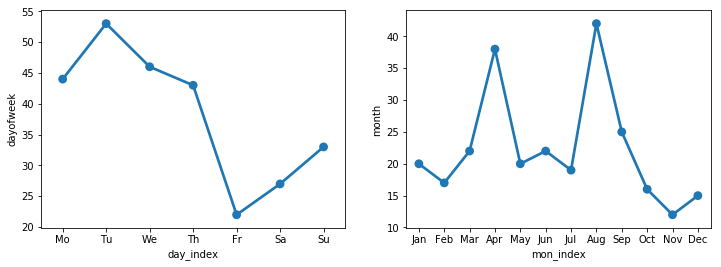

In [85]:
plt.figure(figsize=[12,4])
plt.subplot(121)
sns.pointplot(dayofweek_counts.day_index,dayofweek_counts.dayofweek)

plt.subplot(122)
sns.pointplot(month_counts.mon_index,month_counts.month)

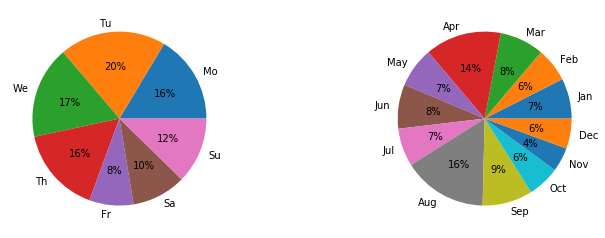

In [86]:
plt.figure(figsize=[12,4])  

labels=dayofweek_counts.day_index
X=dayofweek_counts.dayofweek  
plt.subplot(121)
plt.pie(X,labels=labels,autopct='%1.0f%%') 

labels=month_counts.mon_index
X=month_counts.month  
plt.subplot(122)
plt.pie(X,labels=labels,autopct='%1.0f%%') 

plt.show()

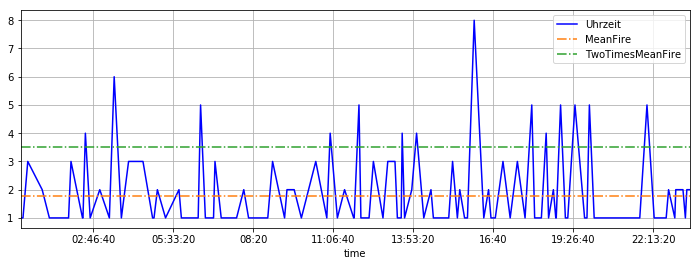

In [119]:
Hour_counts=df['Uhrzeit'].value_counts()
Hour_counts=Hour_counts.to_frame().sort_index()
mean_fire=Hour_counts.Uhrzeit.mean()
Hour_counts['MeanFire']=mean_fire
Hour_counts['TwoTimesMeanFire']=mean_fire*2

Hour_counts.plot(figsize=[8,4],color=['B','C1','C2'],grid=True,style=['-','-.','-.'])

In [191]:
import time
# 四个时间段？
def Transfer_timeofday1(timeofday):
    h_timeofday=int(timeofday.hour)
    if (h_timeofday<6) and (h_timeofday>=0):
        timeofday_part='EMorning'
    elif (h_timeofday<12) and (h_timeofday>=6):
        timeofday_part='Morning'
    elif (h_timeofday<18) and (h_timeofday>=12):
        timeofday_part='Afternoon'
    else:
        timeofday_part='Evening'
        
    return timeofday_part
            
Hour_counts['TimeofDay']=Hour_counts['Uhrzeit_Uhr'].apply(lambda x: Transfer_timeofday1(x))


In [195]:
TimeofDay_part=Hour_counts['TimeofDay'].value_counts()
TimeofDay_part=TimeofDay_part.to_frame().sort_index()

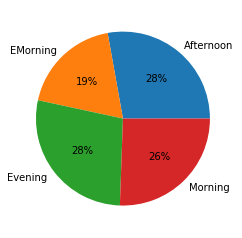

In [196]:
labels=TimeofDay_part.index
X=TimeofDay_part.TimeofDay  
plt.pie(X,labels=labels,autopct='%1.0f%%') 
plt.show()